<a href="https://colab.research.google.com/github/fnjimenez/Curso_Logistica_CV/blob/main/caso_amazon_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Caso Amazon México 2025 - El Buen Fin
### Versión optimizada para Google Colab
Este notebook genera automáticamente el análisis de rutas óptimas de distribución logística para Amazon México durante *El Buen Fin 2025*. Permite ejecutar escenarios base, optimista y pesimista de forma visual.

## 🧩 1. Instalación e importación de librerías

In [1]:
!pip install pulp matplotlib

import os
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from pulp import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 40.9 MB/s eta 0:00:00


## 📦 2. Datos base del modelo

In [2]:
COSTOS_BASE = {
    ('CDMX', 'Toluca'): 8.0, ('CDMX', 'León'): 18.5,
    ('CDMX', 'San Luis Potosí'): 24.0, ('CDMX', 'Cancún'): 135.0,
    ('CDMX', 'Mérida'): 142.0, ('CDMX', 'Veracruz'): 38.0,
    ('Monterrey', 'Toluca'): 52.0, ('Monterrey', 'León'): 45.0,
    ('Monterrey', 'San Luis Potosí'): 33.0, ('Monterrey', 'Cancún'): 128.0,
    ('Monterrey', 'Mérida'): 135.0, ('Monterrey', 'Veracruz'): 85.0,
    ('Guadalajara', 'Toluca'): 38.0, ('Guadalajara', 'León'): 24.0,
    ('Guadalajara', 'San Luis Potosí'): 42.0, ('Guadalajara', 'Cancún'): 148.0,
    ('Guadalajara', 'Mérida'): 155.0, ('Guadalajara', 'Veracruz'): 72.0,
    ('Querétaro', 'Toluca'): 12.0, ('Querétaro', 'León'): 16.0,
    ('Querétaro', 'San Luis Potosí'): 22.0, ('Querétaro', 'Cancún'): 142.0,
    ('Querétaro', 'Mérida'): 148.0, ('Querétaro', 'Veracruz'): 45.0,
    ('Puebla', 'Toluca'): 18.0, ('Puebla', 'León'): 35.0,
    ('Puebla', 'San Luis Potosí'): 48.0, ('Puebla', 'Cancún'): 125.0,
    ('Puebla', 'Mérida'): 132.0, ('Puebla', 'Veracruz'): 28.0,
    ('Tijuana', 'Toluca'): 165.0, ('Tijuana', 'León'): 152.0,
    ('Tijuana', 'San Luis Potosí'): 148.0, ('Tijuana', 'Cancún'): 235.0,
    ('Tijuana', 'Mérida'): 242.0, ('Tijuana', 'Veracruz'): 192.0,
}

DEMANDA_BASE = {
    'Toluca': 27000, 'León': 21000, 'San Luis Potosí': 17000,
    'Cancún': 17000, 'Mérida': 18000, 'Veracruz': 20000
}

OFERTA_BASE = {
    'CDMX': 63000, 'Monterrey': 43000, 'Guadalajara': 37000,
    'Querétaro': 37000, 'Puebla': 22000, 'Tijuana': 22000
}

ORIGENES = list(OFERTA_BASE.keys())
DESTINOS = list(DEMANDA_BASE.keys())

## ⚙️ 3. Funciones principales

In [3]:
def generar_datos_estudiante(id_estudiante):
    factor_ajuste = 0.85 + (id_estudiante % 30) * 0.01
    demanda = {d: int(DEMANDA_BASE[d] * (1 + (id_estudiante % 10)/10)) for d in DESTINOS}
    oferta = {o: int(OFERTA_BASE[o] * (1 + (id_estudiante % 8)/10)) for o in ORIGENES}
    return {'id': id_estudiante, 'factor': factor_ajuste, 'demanda': demanda, 'oferta': oferta, 'costos': COSTOS_BASE}

def resolver_problema(datos):
    demanda, oferta, costos = datos['demanda'], datos['oferta'], datos['costos']
    problema = LpProblem('Amazon', LpMinimize)
    x = LpVariable.dicts('ruta', [(i,j) for i in ORIGENES for j in DESTINOS], 0)
    problema += lpSum(costos[i,j] * x[i,j] for i in ORIGENES for j in DESTINOS)
    for j in DESTINOS: problema += lpSum(x[i,j] for i in ORIGENES) >= demanda[j]
    for i in ORIGENES: problema += lpSum(x[i,j] for j in DESTINOS) <= oferta[i]
    problema.solve(PULP_CBC_CMD(msg=0))
    return {'costo': value(problema.objective), 'asignaciones': {k:int(v.value()) for k,v in x.items() if v.value()>0}}

def crear_diagrama(datos, solucion):
    fig, ax = plt.subplots(figsize=(12,8))
    ax.axis('off')
    origenes, destinos = ORIGENES, DESTINOS
    pos_o = {o:(1.5,y) for o,y in zip(origenes,[7.5,6,4.5,3,1.5,0.5])}
    pos_d = {d:(8.5,y) for d,y in zip(destinos,[7.5,6,4.5,3,1.5,0.5])}
    colores = {'CDMX':'#FF6B6B','Monterrey':'#4ECDC4','Guadalajara':'#45B7D1','Querétaro':'#FFA07A','Puebla':'#98D8C8','Tijuana':'#C7B8EA'}
    for (o,d),f in solucion['asignaciones'].items():
        if f>0:
            x1,y1=pos_o[o]; x2,y2=pos_d[d]
            ax.add_patch(FancyArrowPatch((x1+0.3,y1),(x2-0.3,y2),arrowstyle='->',color=colores[o],lw=1+(f/20000)*3,alpha=0.7))
    for o,(x,y) in pos_o.items(): ax.add_patch(plt.Circle((x,y),0.25,color=colores[o],ec='black')); ax.text(x,y,o,ha='center',va='center')
    for d,(x,y) in pos_d.items(): ax.add_patch(plt.Circle((x,y),0.25,color='#FFD700',ec='black')); ax.text(x,y,d,ha='center',va='center')
    ax.text(5,8.3,f"Red de Distribución - ID {datos['id']}",ha='center',fontsize=14,fontweight='bold')
    plt.show()

## ▶️ 4. Ejecución del modelo

💰 Costo total: $10,349,600.00


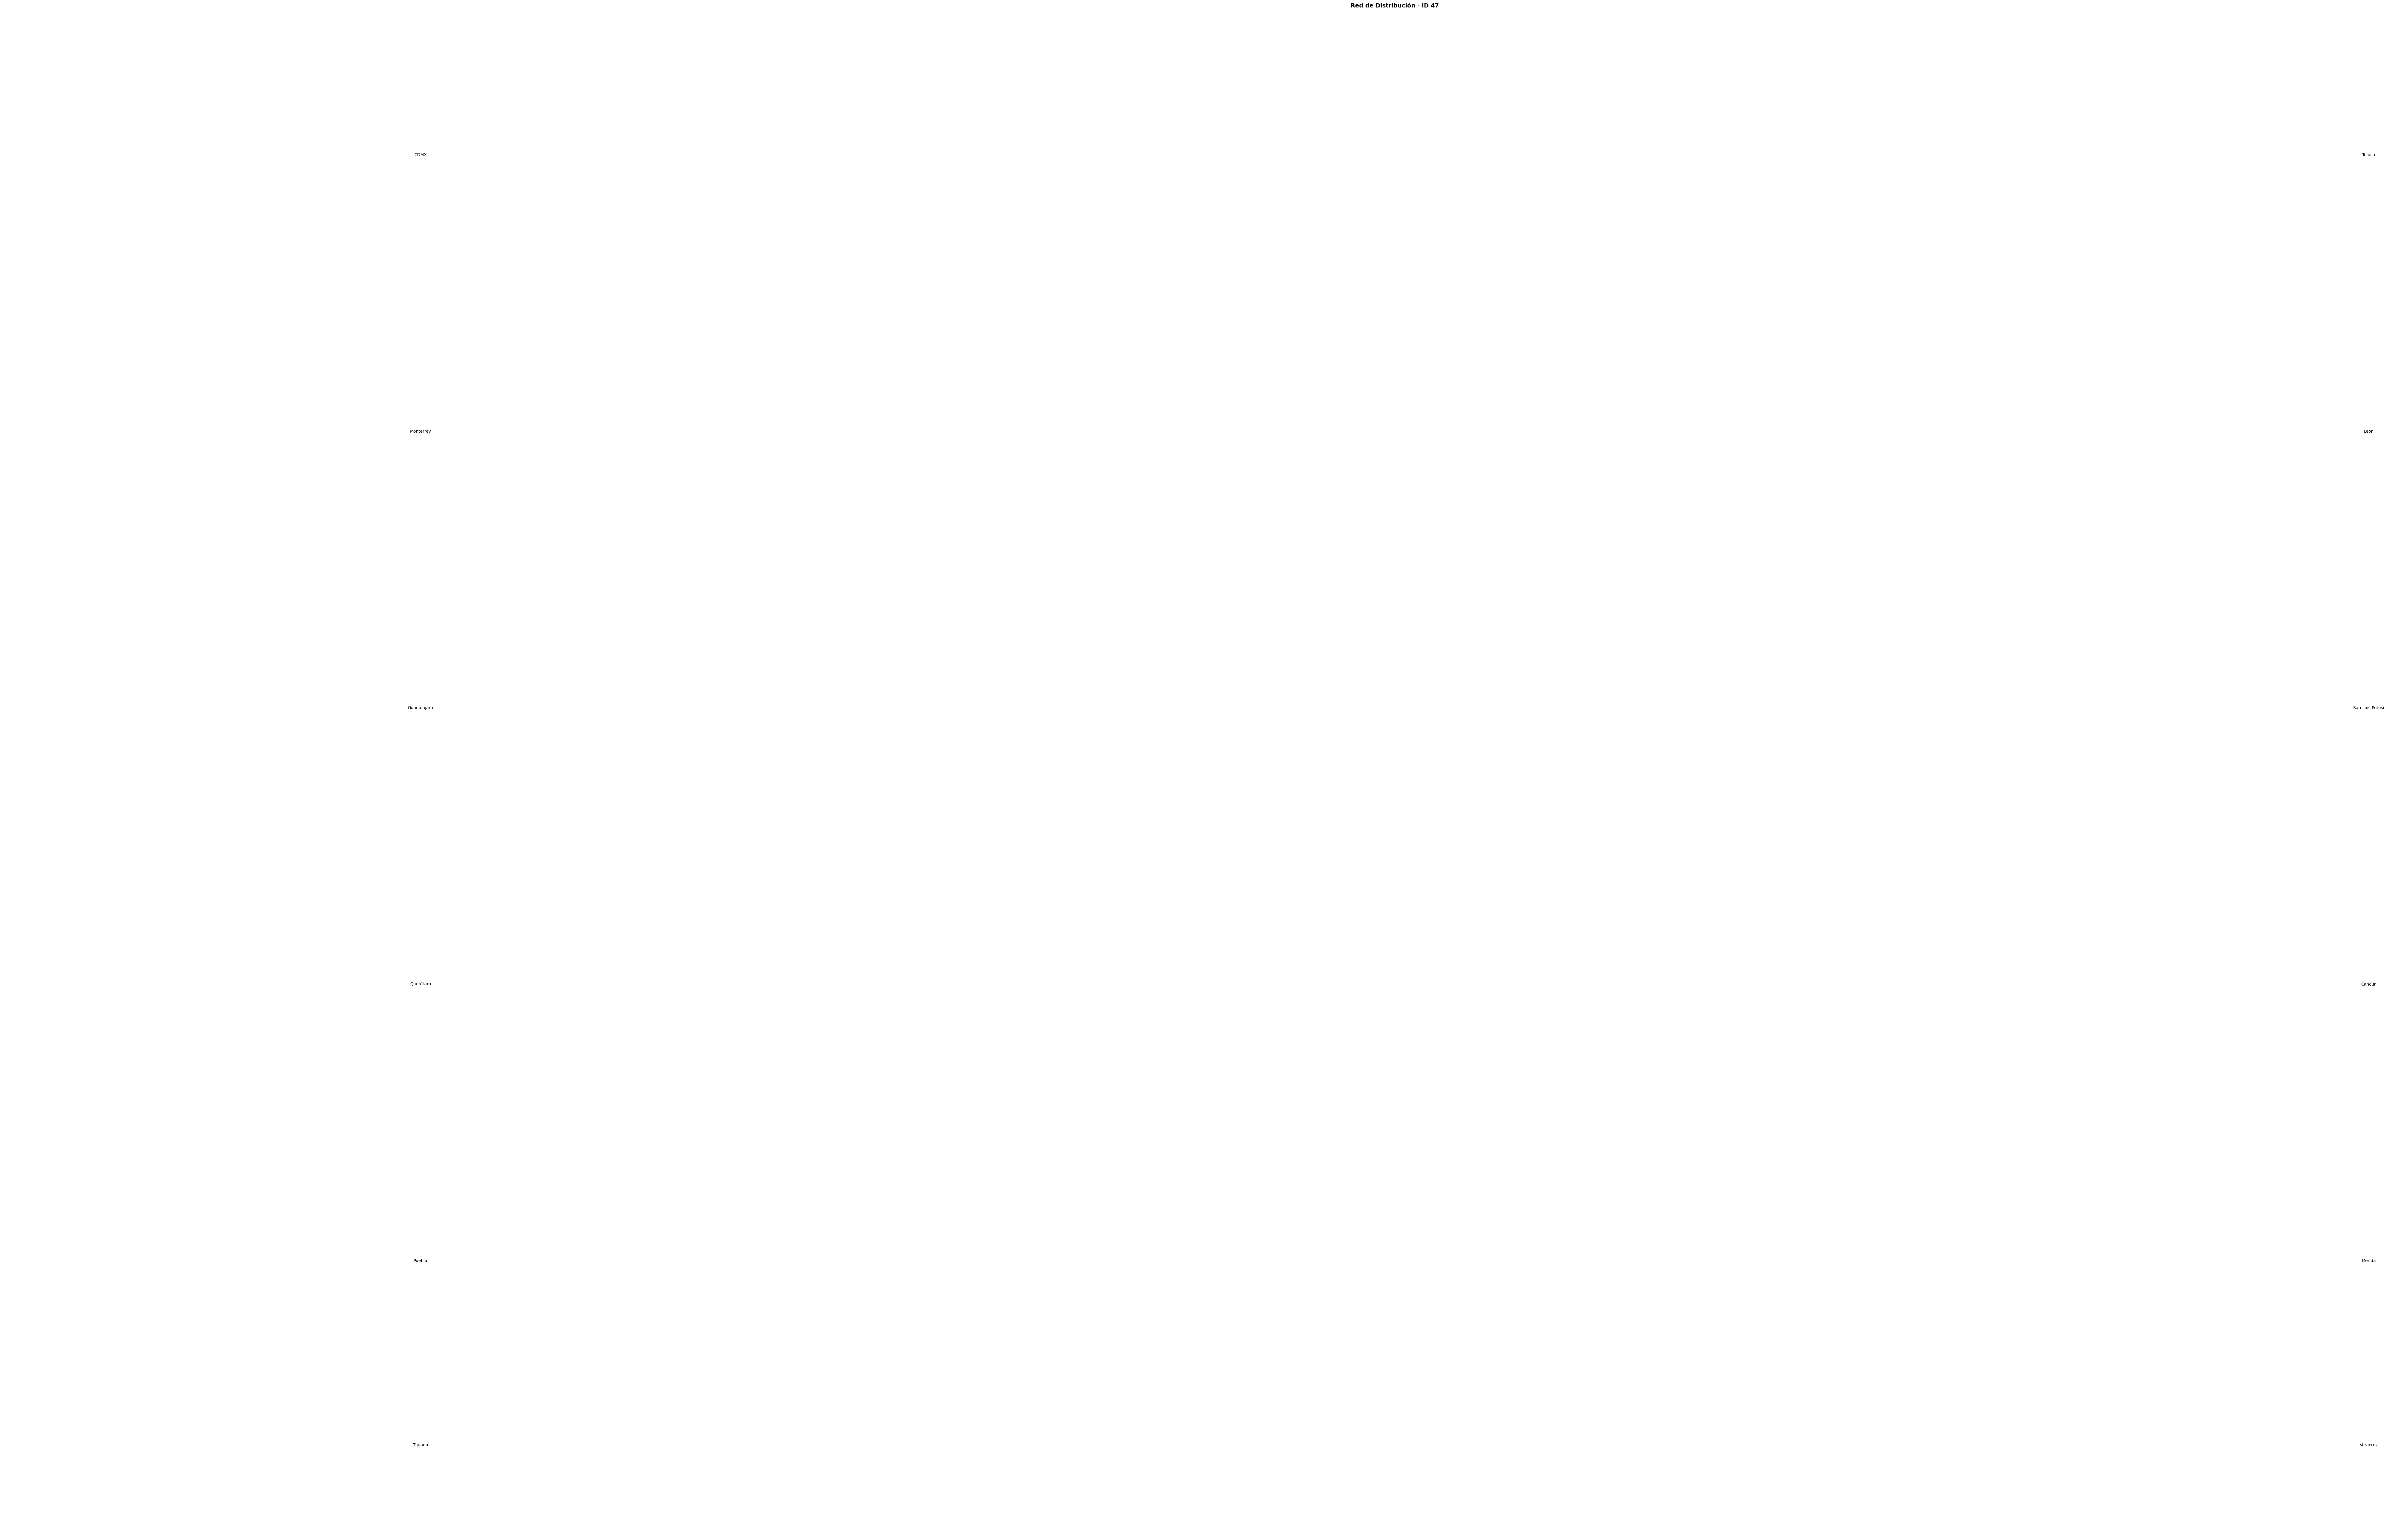

In [4]:
id_estudiante = 47  # Cambia por tus últimos 2 dígitos
datos = generar_datos_estudiante(id_estudiante)
sol = resolver_problema(datos)
print(f"💰 Costo total: ${sol['costo']:,.2f}")
crear_diagrama(datos, sol)